# Flight Fare Prediction

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy import stats

from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score,accuracy_score,confusion_matrix,f1_score,recall_score

## Import data

In [2]:
# Read data from Excel file
df = pd.read_excel(r"Airline_Data.xlsx")

In [3]:
# Display all the columns present in the dataset
pd.set_option('display.max_columns', None)

In [4]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## Data Cleaning

In [5]:
# Get information about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [6]:
# Checking count of 'null' values for each column
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

*** Since there are only a few missing values, we'll drop these rows. *** 

In [7]:
df.shape

(10683, 11)

In [8]:
# Dropping all NaN data
df.dropna(inplace = True)

In [9]:
# Data shape after dropping NaN
df.shape

(10682, 11)

*** Both the missing values belonged to a single row. ***

## Data Preprocessing - Quantitative data

### Preprocessing 'Duration' column

The 'Duration' column is an 'object' type storing duration value as hours and minutes. We need to extract 'hours' and 'minutes' values from this column and store them as separate columns. This will help us process the data easily.


In [10]:
# Get count of each unique value of 'Duration' column
df["Duration"].value_counts()

2h 50m     550
1h 30m     386
2h 45m     337
2h 55m     337
2h 35m     329
          ... 
31h 30m      1
30h 25m      1
42h 5m       1
4h 10m       1
47h 40m      1
Name: Duration, Length: 368, dtype: int64

In [11]:
# Getting values from 'Duration' column into a list
lst_duration = list(df["Duration"])

# Ensure that this column contains both 'hours' and 'minutes' values.
# Append any missing values
for i in range(len(lst_duration)):  
    if len(lst_duration[i].split()) != 2:                       # Check if duration contains only hour or mins
        if "h" in lst_duration[i]:
            lst_duration[i] = lst_duration[i].strip() + " 0m"   # Adds '0m' as 'minutes' is missing  
        else:
            lst_duration[i] = "0h " + lst_duration[i]           # Adds '0h' as 'hours' is missing 

# Store 'hours' and 'minutes' values in arrays
hrs_dur = []
mins_dur = []

# Extract hours & minutes from the duration list, and store them in arrays
for i in range(len(lst_duration)):
    
    hours = int(lst_duration[i].split(sep = "h")[0])
    mins = int(lst_duration[i].split(sep = "m")[0].split()[-1])
    hrs_dur.append(hours)                
    mins_dur.append(mins)   

In [12]:
# Adding 'hours' and 'minutes' values as columns in the dataset

df["DurationHours"] = hrs_dur
df["DurationMinutes"] = mins_dur

# Dropping 'Duration' column
df.drop(["Duration"], axis = 1, inplace = True)

### Preprocessing 'Date_of_Journey' column

Similarly, the 'Date_of_Journey' column is an 'object' type storing values as hours and minutes. 'hours' and 'minutes' values need to be extracted and stored as separate columns.


In [13]:
## Extracting 'day' and 'month' from the 'Date_of_Journey' column.

# Convert the 'object' datatype to 'datetime' datatype
journeyDate = pd.to_datetime(df["Date_of_Journey"], format="%d/%m/%Y")

df["JourneyDay"] = journeyDate.dt.day
df["JourneyMonth"] = journeyDate.dt.month

In [14]:
# Dropping 'Date_of_Journey' column
df.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [15]:
df.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,DurationHours,DurationMinutes,JourneyDay,JourneyMonth
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,non-stop,No info,3897,2,50,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,2 stops,No info,7662,7,25,1,5
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,2 stops,No info,13882,19,0,9,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,1 stop,No info,6218,5,25,12,5
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,1 stop,No info,13302,4,45,1,3


### Preprocessing 'Dep_Time' and 'Arrival_Time' columns

Extracting 'hours' and 'minutes' from 'Dep_Time' and 'Arrival_Time' columns

In [16]:
## Extracting 'hours' and 'minutes' from the 'Dep_Time' column

# Convert the 'object' datatype to 'datetime' datatype
departureTime = pd.to_datetime(df["Dep_Time"])

df["DepartureHour"] = departureTime.dt.hour
df["DepartureMinute"] = departureTime.dt.minute

# Dropping 'Date_of_Journey' column
df.drop(["Dep_Time"], axis = 1, inplace = True)

In [17]:
## Extracting 'hours' and 'minutes' from the 'Arrival_Time' column

# Convert the 'object' datatype to 'datetime' datatype
arrivalTime = pd.to_datetime(df.Arrival_Time)

df["ArrivalHour"] = arrivalTime.dt.hour
df["ArrivalMinute"] = arrivalTime.dt.minute

# Dropping 'Arrival_Time' column
df.drop(["Arrival_Time"], axis = 1, inplace = True)

In [18]:
df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,DurationHours,DurationMinutes,JourneyDay,JourneyMonth,DepartureHour,DepartureMinute,ArrivalHour,ArrivalMinute
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,2,50,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,7,25,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,19,0,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,5,25,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,4,45,1,3,16,50,21,35


### Check for Outliers

Now that column values are in a processable format, we can check for outliers 

In [19]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Price,10682.0,9087.214567,4611.548810,1759.0,5277.0,8372.0,12373.0,79512.0
DurationHours,10682.0,10.244898,8.494916,0.0,2.0,8.0,15.0,47.0
DurationMinutes,10682.0,28.326624,16.945817,0.0,15.0,30.0,45.0,55.0
JourneyDay,10682.0,13.509081,8.479363,1.0,6.0,12.0,21.0,27.0
JourneyMonth,10682.0,4.708575,1.164408,3.0,3.0,5.0,6.0,6.0
DepartureHour,10682.0,12.491013,5.748820,0.0,8.0,11.0,18.0,23.0
DepartureMinute,10682.0,24.409287,18.767801,0.0,5.0,25.0,40.0,55.0
ArrivalHour,10682.0,13.349186,6.859317,0.0,8.0,14.0,19.0,23.0
ArrivalMinute,10682.0,24.690601,16.506808,0.0,10.0,25.0,35.0,55.0


*** Columns whose MAX or MIN value is very different from the MEAN value, have outliers. ***

*** This is because the mean is sensitive to outliers, and the fact the mean is so small compared to the min/max value indicates the min/max value is an outlier. ***

*** For example, in 'Price' column, the MAX value is approximately 79500 while its mean is around 9100. So, 79500 is definitely an outlier ***

In [20]:
## 1st Find columns that have potential outliers

outliers = (df.select_dtypes(['float' , 'int'])
 .apply(lambda x: (x >  plt.boxplot(x)['whiskers'][1].get_ydata()[1] ) 
        | (x <  plt.boxplot(x)['whiskers'][0].get_ydata()[1] ) ))
plt.close()

(outliers).mean()*100

Price              0.879985
DurationHours      0.683393
DurationMinutes    0.000000
JourneyDay         0.000000
JourneyMonth       0.000000
DepartureHour      0.000000
DepartureMinute    0.000000
ArrivalHour        0.000000
ArrivalMinute      0.000000
dtype: float64

*** Columns with non-zero values have outliers.  ***

*** 'Price' and 'DurationHours' columns have outliers. *** 


In [21]:
# Calculate the number of outlying observations in each column

q1 = df.quantile(0.25)
q3 = df.quantile(0.75)

IQR = q3 - q1

# Number of outliers in each column
((df < (q1 - 1.5 * IQR)) | (df > (q3 + 1.5 * IQR))).sum()

C:\Users\shail\AppData\Local\Temp\ipykernel_37152\3948411872.py:9: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  ((df < (q1 - 1.5 * IQR)) | (df > (q3 + 1.5 * IQR))).sum()


Additional_Info     0
Airline             0
ArrivalHour         0
ArrivalMinute       0
DepartureHour       0
DepartureMinute     0
Destination         0
DurationHours      73
DurationMinutes     0
JourneyDay          0
JourneyMonth        0
Price              94
Route               0
Source              0
Total_Stops         0
dtype: int64

<AxesSubplot:xlabel='Price'>

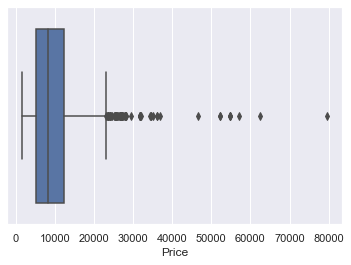

In [22]:
# Analize 'Price' column using Box-plot

sns.boxplot(x=df['Price'])


*** The Price column has 94 outliers. Dropping them is not a good idea for several reasons:

- These values indicate the cost of business class/ first class tickets, which are important to our investigation (below plot confirms this finding).
- We would lose a lot of information if we dropped 94 rows.

***
So, a better approach would be to transform this column and use tree-based algorithms, which are robust to outliers.

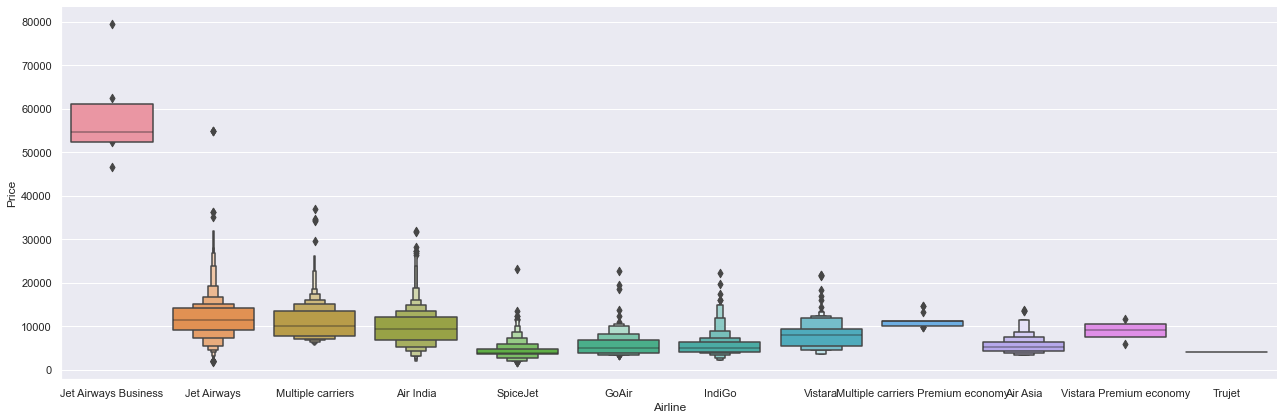

In [23]:
# From graph we can see that Jet Airways Business have the highest Price.
# Apart from the first Airline almost all are having similar median

# Price vs Airline
sns.catplot(y = "Price", x = "Airline", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

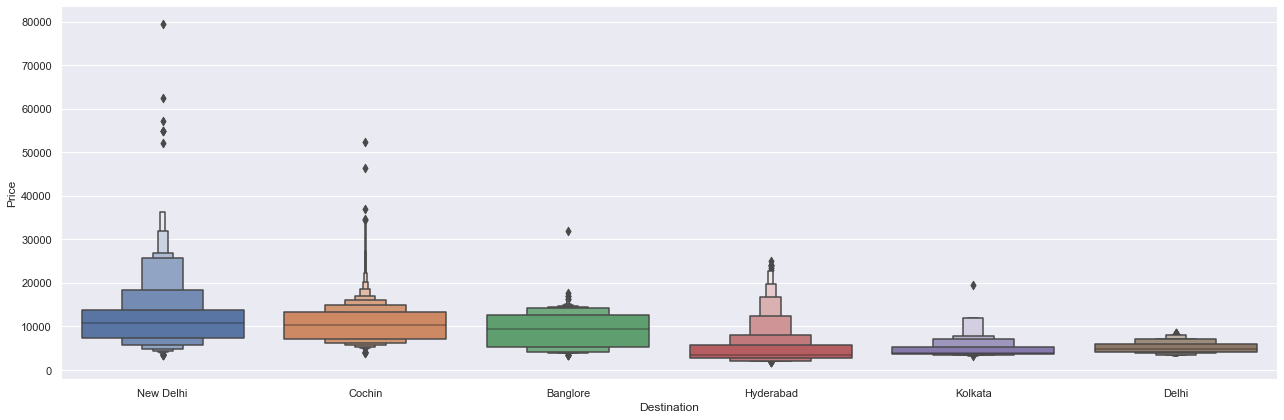

In [24]:
# Price vs Destination
sns.catplot(y = "Price", x = "Destination", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

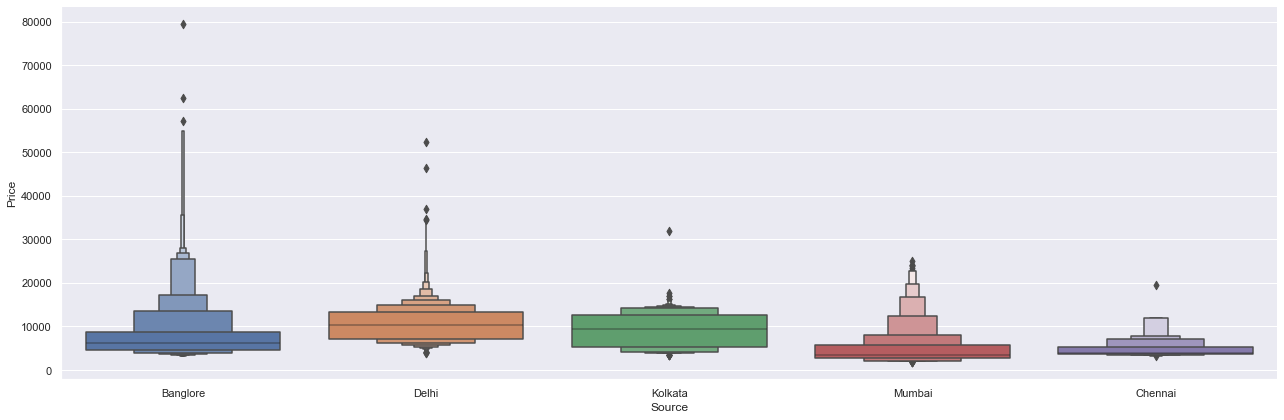

In [25]:
# Price vs Source
sns.catplot(y = "Price", x = "Source", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

<AxesSubplot:xlabel='DurationHours'>

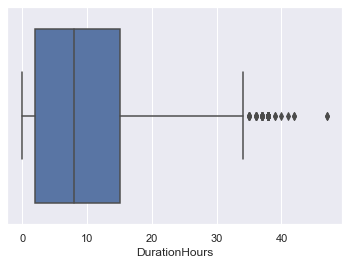

In [26]:
# Analyze 'these' columns using Box-plot

sns.boxplot(x=df['DurationHours'])

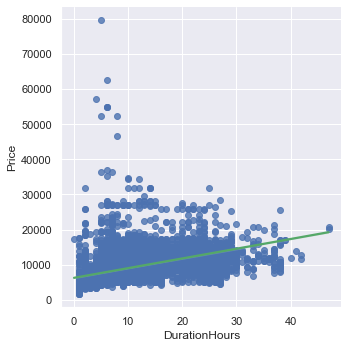

In [27]:
# Scatter plot with smooth curve
p1 = sns.lmplot(data=df, x='DurationHours', y='Price', line_kws={'color': 'g'}   
               , truncate=True)
plt.xlabel("DurationHours")
plt.ylabel("Price")

plt.show()

*** Some flight do have unusually long durations, and these flights offer low-cost tickets. We have 73 outlying observations in this feature, so dropping these values would result in information loss.  ***

Here too, we will transform this column and use tree-based algorithms, which are robust to outliers.

## Pairplot to check distribution shape and relationship type between variables

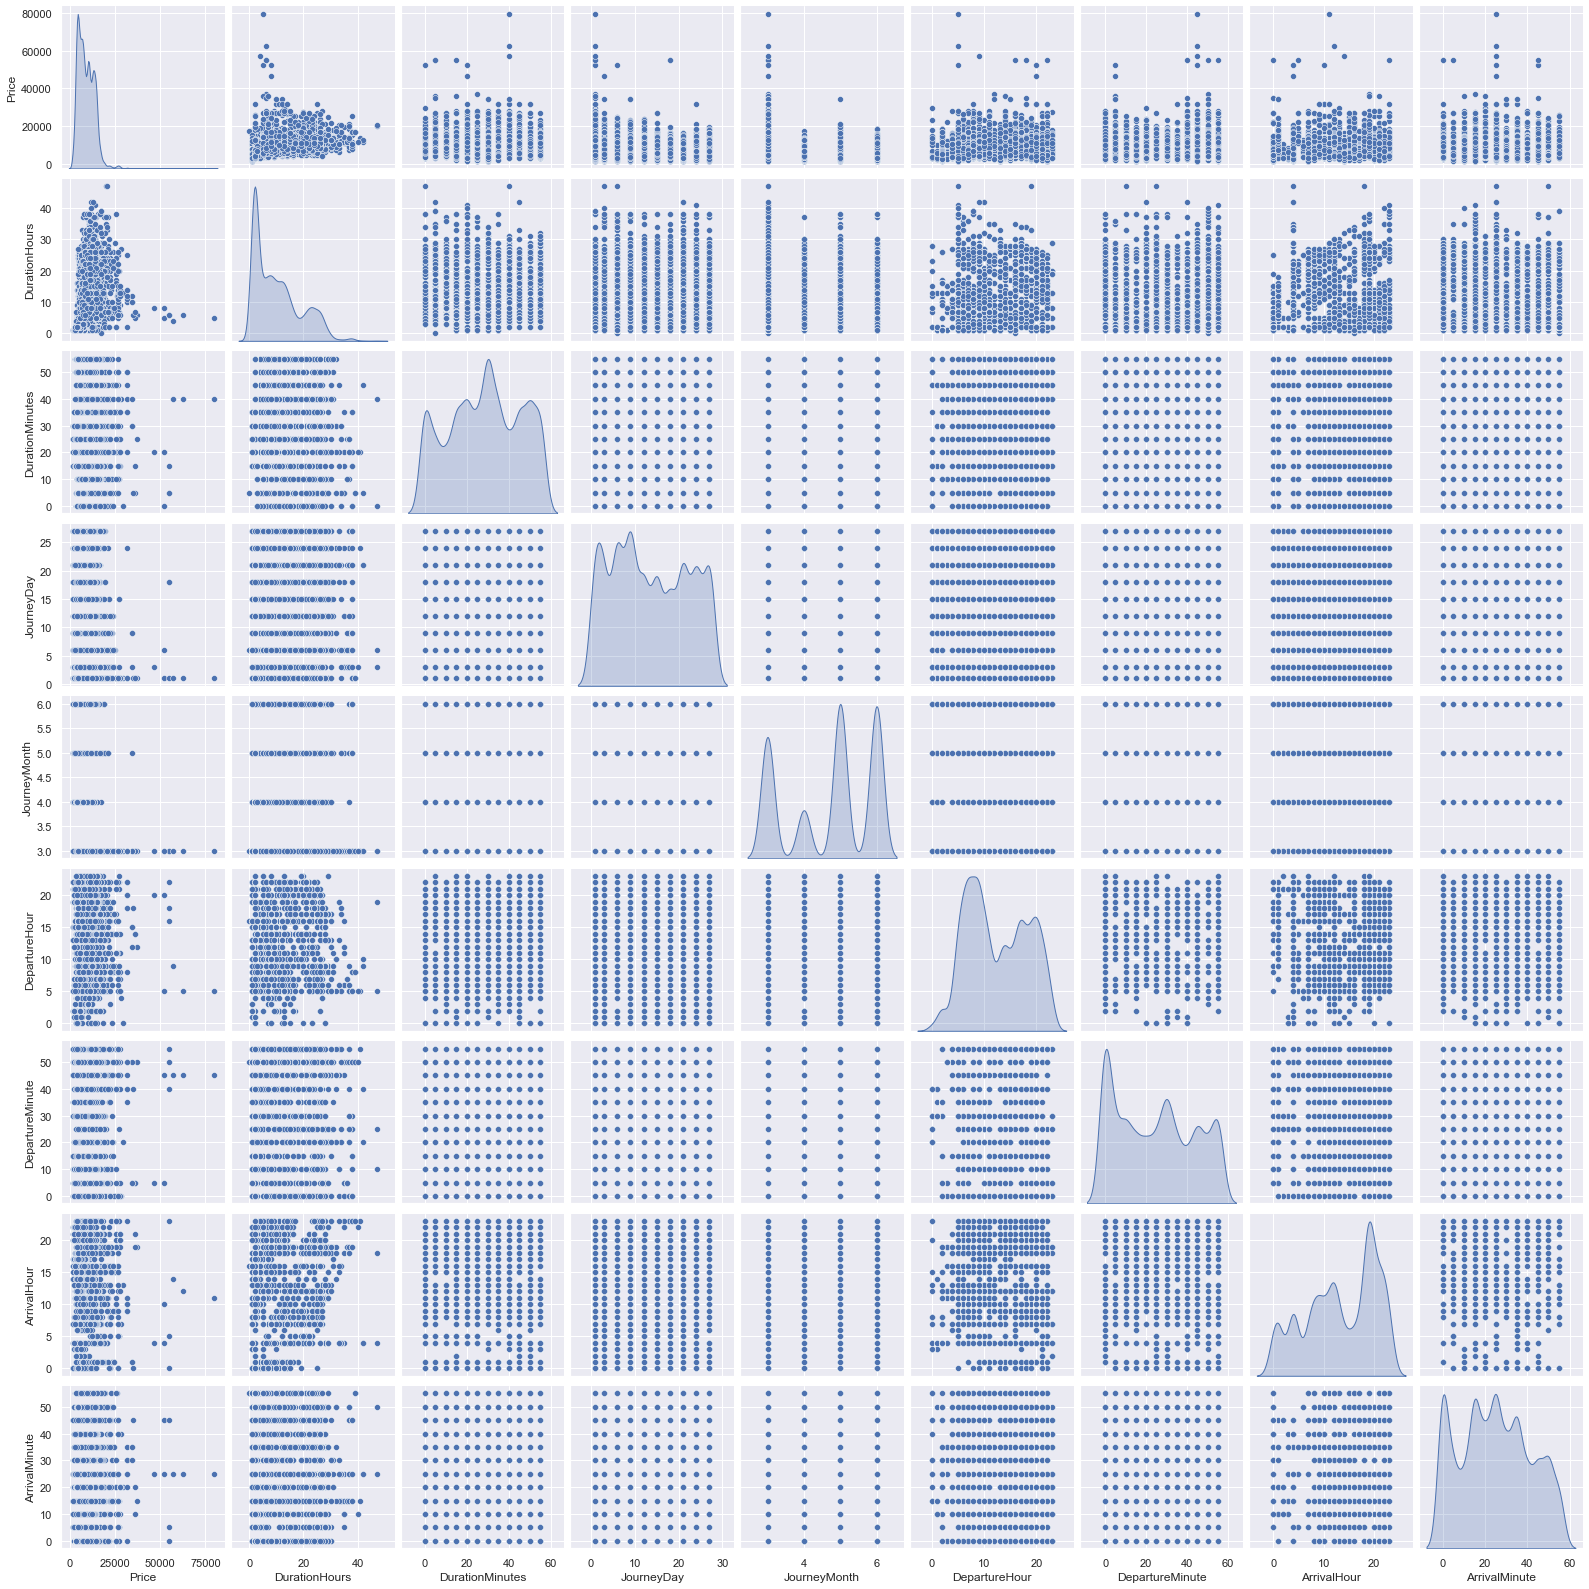

In [28]:
sns.pairplot(df, diag_kind='kde')

*** SKEWNESS ***

*** The 'Price' and 'DistributionHours' features look positively skewed. Other features follow multi-modal distributions, however they do not show high skewness. ***

In [29]:

num_feats = df.dtypes[df.dtypes != 'object'].index

skew_feats = df[num_feats].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skew_feats})
skewness


,Skew
Price,1.812405
DurationHours,0.851197
DepartureMinute,0.167234
JourneyDay,0.118174
DepartureHour,0.112924
ArrivalMinute,0.110945
DurationMinutes,-0.090680
ArrivalHour,-0.370146
JourneyMonth,-0.387409


*** The skew() calculates the Fisher–Pearson standardized moment coefficient, and it follows the below mentioned rule:  ***

*** < 0.5: fairly symmetrical *** 

*** 0.5 to 1.0: moderately skewed ***

*** > 1.0: Highly skewed ***

So, the 'Price' column is highly skewed, and the 'DurationHours' column is moderately skewed. This could be due presence of outliers.  

Linear Regression models follow the assumption that the distribution of variables is Normal. Although there are regression models that are robust to skewness, it's a good practice to transform the data to reduce skewness.

We'll try several methods to see which works best.

### Handle skewness

In [30]:
df['DurationHours'].skew()

0.8511967493842577

<AxesSubplot:xlabel='DurationHours', ylabel='Count'>

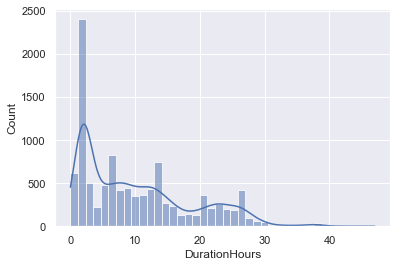

In [31]:
# Plot histogram

sns.histplot(data = df['DurationHours'], kde = True)

In [32]:
# Log Transform

DurationHours_log = np.log(df['DurationHours'])
DurationHours_log.skew()

C:\Users\shail\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


nan

*** Log transform doesn't work for this column. ***

In [33]:
# Square root transform

DurationHours_sqrt = np.sqrt(df['DurationHours'])
DurationHours_sqrt.skew()

0.2889374290765905

<AxesSubplot:xlabel='DurationHours', ylabel='Count'>

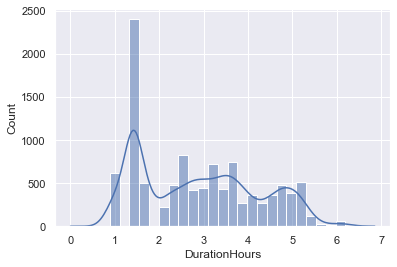

In [34]:
# Plot histogram

sns.histplot(data = DurationHours_sqrt, kde = True)

In [35]:
# Box-Cox transform

# DurationHours_boxcox = stats.boxcox(df['DurationHours'])[0]
# pd.Series(DurationHours_boxcox).skew()

*** Since Box-cox transform and Log Transform doesn't work for this column, we'll go with Square root transform. ***



In [36]:
# Add 'Price_log' column to the dataframe

df['DurationHours'] = DurationHours_sqrt

In [37]:
# Transforming 'Price' column

Price_log = np.log(df['Price'])
Price_log.skew()

-0.25476338907926027

<AxesSubplot:xlabel='Price', ylabel='Count'>

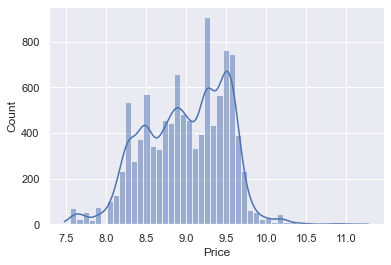

In [38]:
sns.histplot(data = Price_log, kde = True)

*** Log transform performed very heavy transformation, thus making the distribution from highly positively skewed to slightly negatively skewed. We can try a milder transformation. ***

In [39]:
# Square root transform

Price_sq = np.sqrt(df['Price'])
Price_sq.skew()

0.43165966673613076

*** The distribution is still positively skewed, but only slightly ***

In [40]:
# Boxcox transform

Price_bc = stats.boxcox(df['Price'])[0]
pd.Series(Price_bc).skew()

-0.012113174645484403

* The distribution is almost Normal. We'll choose this. *

<AxesSubplot:ylabel='Count'>

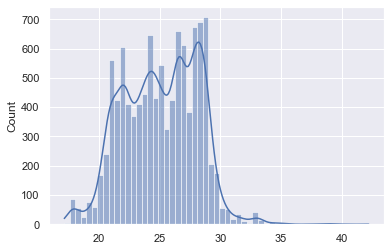

In [41]:
sns.histplot(data = Price_bc, kde = True)

In [42]:
df['Price'] = Price_bc

In [43]:
df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,DurationHours,DurationMinutes,JourneyDay,JourneyMonth,DepartureHour,DepartureMinute,ArrivalHour,ArrivalMinute
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,20.949458,1.414214,50,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,24.679604,2.645751,25,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,28.398426,4.358899,0,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,23.473595,2.236068,25,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,28.116518,2.000000,45,1,3,16,50,21,35


### Check relationship between dependent and continuous variables

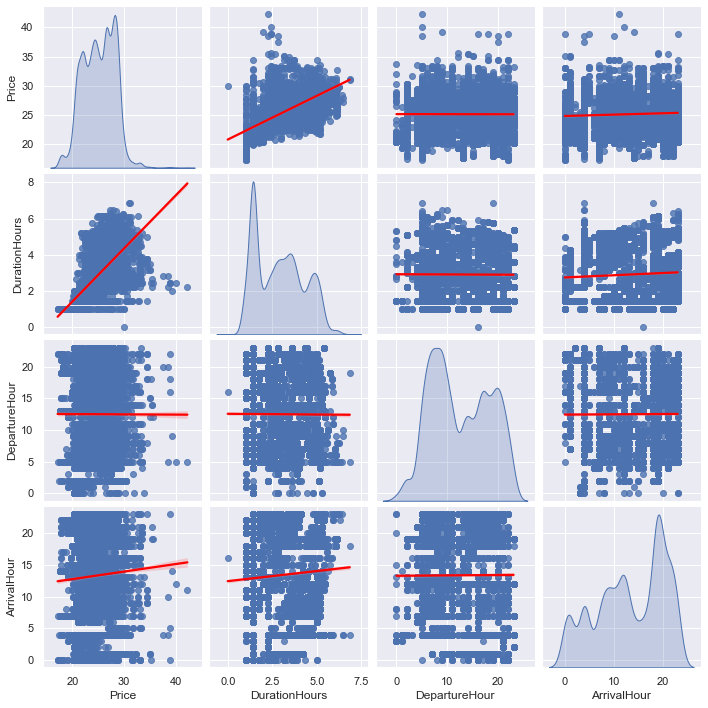

In [44]:
# Adding regression lines for continuous variables

###### TAKE OUT CORRELATION #######

continuous_cols = ['Price', 'DurationHours', 'DepartureHour', 'ArrivalHour']

df[continuous_cols].corr()

sns.pairplot(df[continuous_cols], kind='reg', diag_kind='kde',
             plot_kws={'line_kws':{'color':'red'}})

*** 'Price' seems to have a correlation with 'Duration' column, although they are not strongly very correlated since the data points are greatly scattered around the regression line.  ***

*** Since there are no other independent variables that have strong correlation with the dependent variable, linear models are not a good choice. Tree based models like 'Decision Tree', 'Random Forest' or clustering models 'KNN Regressor' seems like a good choice for this case. ***

# Preparing data for ML model¶

Following steps will make the data ready for the ML model:

1. Encoding Categorical variables
2. Train-test split
3. Feature Scaling (Normalization)
4. Feature Selection

## Categorical Variable Encoding

Nominal data: OneHotEncoding

Ordinal data: LabelEncoding

In [45]:
# As Airline, Source, Destination are Nominal Categorical data, we will perform OneHotEncoding

Airline = df[["Airline"]]
Airline = pd.get_dummies(Airline, drop_first= True)
Airline.head()

,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [46]:
Source = df[["Source"]]
Source = pd.get_dummies(Source, drop_first= True)
Source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [47]:
Destination = df[["Destination"]]
Destination = pd.get_dummies(Destination, drop_first = True)
Destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [48]:
df["Total_Stops"].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [49]:
# As Total_Stops is an Ordinal Categorical type, we'll perform LabelEncoding

df.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)
df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,DurationHours,DurationMinutes,JourneyDay,JourneyMonth,DepartureHour,DepartureMinute,ArrivalHour,ArrivalMinute
0,IndiGo,Banglore,New Delhi,BLR → DEL,0,No info,20.949458,1.414214,50,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2,No info,24.679604,2.645751,25,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2,No info,28.398426,4.358899,0,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1,No info,23.473595,2.236068,25,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1,No info,28.116518,2.000000,45,1,3,16,50,21,35


In [50]:
# Concatenate encoded columns to the dataframe --> df + Airline + Source + Destination

df_encoded = pd.concat([df, Airline, Source, Destination], axis = 1)
df_encoded.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,DurationHours,DurationMinutes,JourneyDay,JourneyMonth,DepartureHour,DepartureMinute,ArrivalHour,ArrivalMinute,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,IndiGo,Banglore,New Delhi,BLR → DEL,0,No info,20.949458,1.414214,50,24,3,22,20,1,10,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2,No info,24.679604,2.645751,25,1,5,5,50,13,15,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2,No info,28.398426,4.358899,0,9,6,9,25,4,25,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1,No info,23.473595,2.236068,25,12,5,18,5,23,30,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1,No info,28.116518,2.000000,45,1,3,16,50,21,35,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Dropping all unnecessary columns from df_encoded

In [51]:
df["Additional_Info"].value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

*** Almost 80% of the values in the 'Additional_Info' column are 'no_info'. So we'll drop this column as it does not add value to our study. ***

In [52]:
# Dropping 'Additional_Info' columns

df_encoded.drop(["Additional_Info"], axis = 1, inplace = True)

In [53]:
df["Route"].value_counts()

DEL → BOM → COK          2376
BLR → DEL                1552
CCU → BOM → BLR           979
CCU → BLR                 724
BOM → HYD                 621
                         ... 
CCU → VTZ → BLR             1
CCU → IXZ → MAA → BLR       1
BOM → COK → MAA → HYD       1
BOM → CCU → HYD             1
BOM → BBI → HYD             1
Name: Route, Length: 128, dtype: int64

*** Information provided by the 'Route' column can be captured using 'Source', 'Destination' and 'Total_stops' columns. It does not provide any additional information, so we'll drop this column. ***

In [54]:
# Dropping 'Route' column

df_encoded.drop(["Route"], axis = 1, inplace = True)

In [55]:
# Dropping the original(unencoded) Airline, Source, Destination columns

df_encoded.drop(["Airline","Source", "Destination"], axis = 1, inplace = True)
df_encoded.head()

,Total_Stops,Price,DurationHours,DurationMinutes,JourneyDay,JourneyMonth,DepartureHour,DepartureMinute,ArrivalHour,ArrivalMinute,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,20.949458,1.414214,50,24,3,22,20,1,10,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,24.679604,2.645751,25,1,5,5,50,13,15,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,28.398426,4.358899,0,9,6,9,25,4,25,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,1,23.473595,2.236068,25,12,5,18,5,23,30,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,28.116518,2.000000,45,1,3,16,50,21,35,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [56]:
df_encoded.shape

(10682, 30)

## Feature Selection

Following methods are used for feature selection:

1. heatmap - to get rid of multicollinearity
2. feature_importance_ - to get the most important features

### Remove multicollinearity

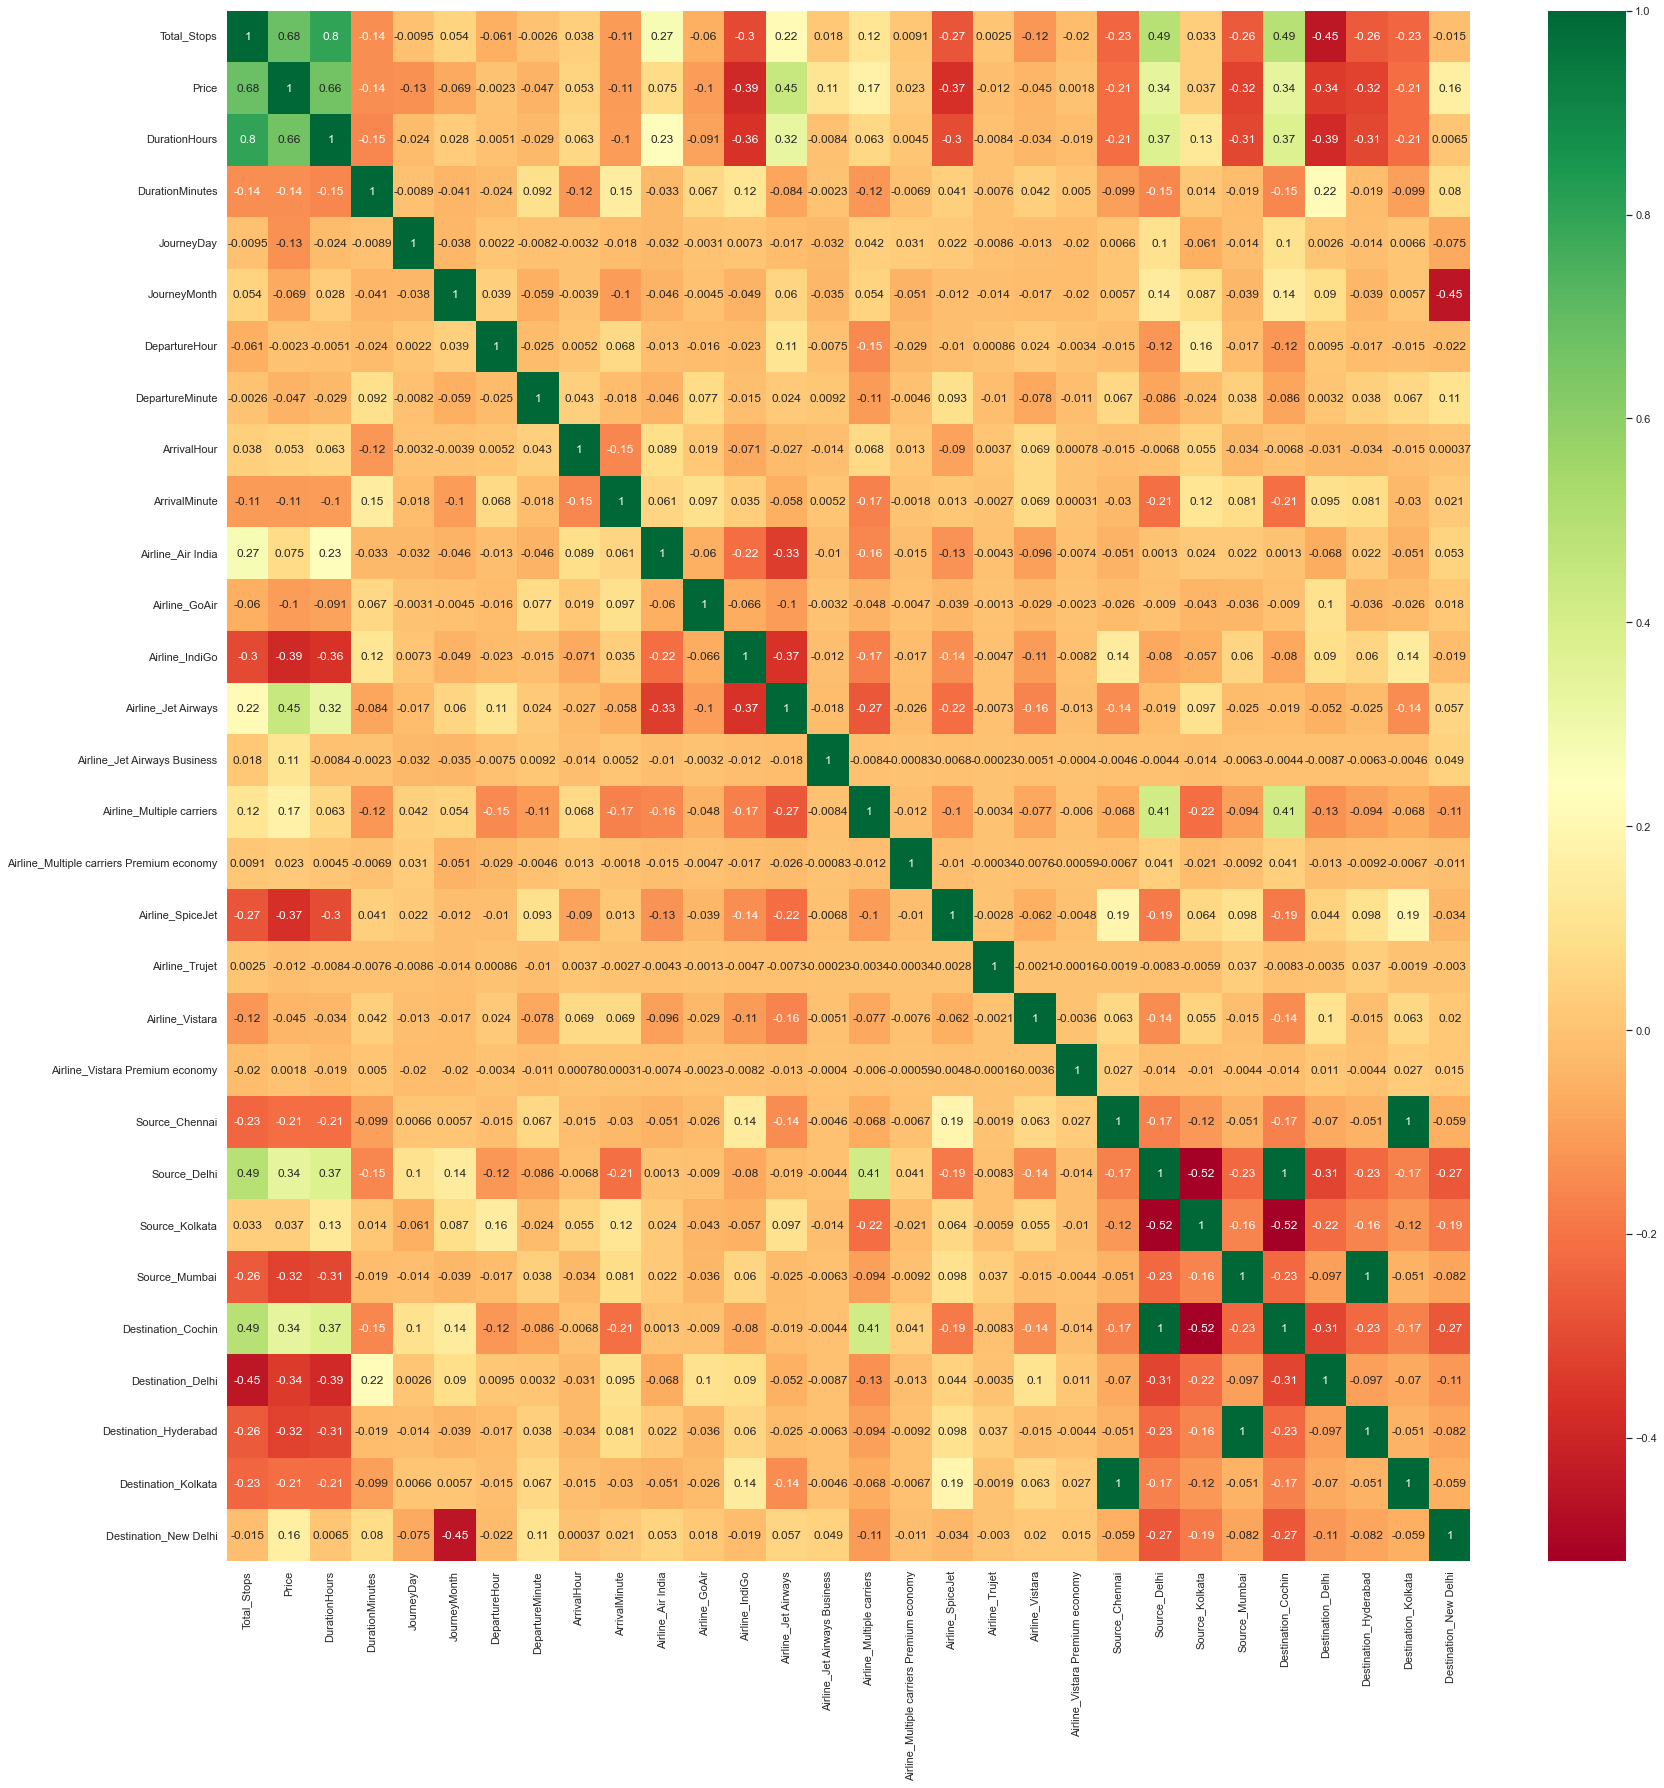

In [57]:
# Finds correlation among variables

plt.figure(figsize = (25,25))
sns.heatmap(df_encoded.corr(), annot = True, cmap = "RdYlGn")
plt.tight_layout()
plt.show()

In [58]:
# Dropping columns which show multicollinearity

df_encoded.drop(["Source_Chennai"], axis = 1, inplace = True)
df_encoded.drop(["Source_Mumbai"], axis = 1, inplace = True)
df_encoded.drop(["Source_Delhi"], axis = 1, inplace = True)
df_encoded.drop(["DurationHours"], axis = 1, inplace = True)

# Without the 'DurationHours' column, 'DurationMinutes' column doesn't make sense. 
# So we'll drop it too.
df_encoded.drop(["DurationMinutes"], axis = 1, inplace = True)



## Train/ Test split

In [59]:
## PREPARE THE DATA FOR ML MODEL
# 1. Split the data into train and test
# 2. separate the independent and dependent features
# 3. shuffle the dataset

x_train, x_test = train_test_split(df_encoded, test_size=0.2, random_state=0)

# DEPENDENT features
# get the training label
y_train = x_train["Price"]

# get the test label
y_test = x_test["Price"]


# INDEPENDENT features
# remove the label from train and test data
x_train.pop("Price")
x_test.pop("Price")


y_train.head()
#you may have noticed that the index, the left most column is already shuffled

508     25.873660
3071    22.016184
2036    29.875230
49      26.975846
9686    22.050953
Name: Price, dtype: float64

In [60]:
x_train.shape

(8545, 24)

In [61]:
x_test.shape

(2137, 24)

## Feature Scaling - Normalize data

In [62]:
# define min max scaler
scaler = MinMaxScaler()

# transform data
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

## Linear Regression

In [63]:
# loading the linear regression model 

linReg_model = LinearRegression() 
linReg_model.fit(X_train,y_train) 

y_pred_lr = linReg_model.predict(X_test)

## Equation
print('--------- Coefficients --------------')
print(linReg_model.coef_)

## Calculate metrics

# training accuracy
train_acc_lr = linReg_model.score(X_train, y_train)

# test accuracy
test_acc_lr = linReg_model.score(X_test, y_test)

print('--------- Metrics --------------')
print('Training accuracy:', train_acc_lr)
print('Test accuracy:', test_acc_lr)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_lr))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_lr))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)))

--------- Coefficients --------------
[ 5.48032565e+00 -1.08936391e+00 -6.97825423e-01  1.51323034e-01
 -7.43127833e-02 -4.28311693e-02  5.63041021e-02  1.40796580e+00
  9.88554591e-02  2.57459070e-01  3.17075074e+00  1.44904751e+01
  2.66004337e+00  3.14147189e+00 -5.59156196e-01 -1.05895405e+00
  1.90316396e+00  2.67966414e+00 -1.11218380e+12 -1.11218380e+12
 -1.11218380e+12 -1.11218380e+12 -1.11218380e+12 -1.11218380e+12]
--------- Metrics --------------
Training accuracy: 0.7130557904616761
Test accuracy: 0.7074114101904587
MAE: 1.2533236511524437
MSE: 2.845920939414921
RMSE: 1.6869857555459444


*** As we see, Linear Regression model gives very low accuracy. ***

So, we'll try other regression models.

## Extra Tree Regressor


In [64]:
from sklearn.ensemble import ExtraTreesRegressor

extraReg_model = ExtraTreesRegressor()
extraReg_model.fit(X_train, y_train)

y_pred_er = extraReg_model.predict(X_test)


## Calculate metrics

# training accuracy
train_acc_er = extraReg_model.score(X_train, y_train)

# test accuracy
test_acc_er = extraReg_model.score(X_test, y_test)

print('--------- Metrics --------------')
print('Training accuracy:', train_acc_er)
print('Test accuracy:', test_acc_er)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_er))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_er))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_er)))

--------- Metrics --------------
Training accuracy: 0.9735583887298368
Test accuracy: 0.8162984773298471
MAE: 0.8218973546001933
MSE: 1.7868092884609967
RMSE: 1.3367158592838633


## Random Forest 

In [65]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)


y_pred_rf = reg_rf.predict(X_test)


## Calculate metrics

# training accuracy
train_acc_rf = reg_rf.score(X_train, y_train)

# test accuracy
test_acc_rf = reg_rf.score(X_test, y_test)

print('--------- Metrics --------------')
print('Training accuracy:', train_acc_rf)
print('Test accuracy:', test_acc_rf)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_rf))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_rf))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))

--------- Metrics --------------
Training accuracy: 0.9633840096892775
Test accuracy: 0.8493864408675666
MAE: 0.7781876069896151
MSE: 1.464972649732569
RMSE: 1.2103605453469513


*** This has a much better test accuracy and lower error values, compared to Extra Tree Regressor. So we'll use this model. ***


C:\Users\shail\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


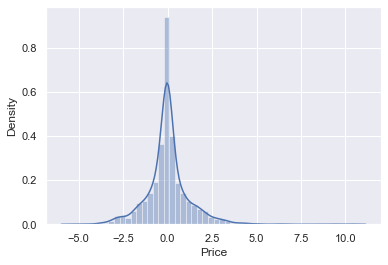

In [66]:
# Visualizing Residuals

sns.distplot(y_test-y_pred_rf)
plt.show()

C:\Users\shail\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


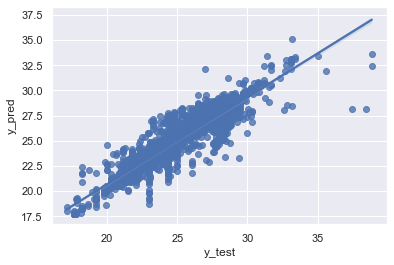

In [67]:
sns.regplot(y_test, y_pred_rf)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

*** Actual and predicted values lie in a straight line. This shows the prediction is quite close to actual values.  ***

In [68]:
metrics.r2_score(y_test, y_pred_rf)

0.8493864408675666

*** The r-squared value is quite good. ***

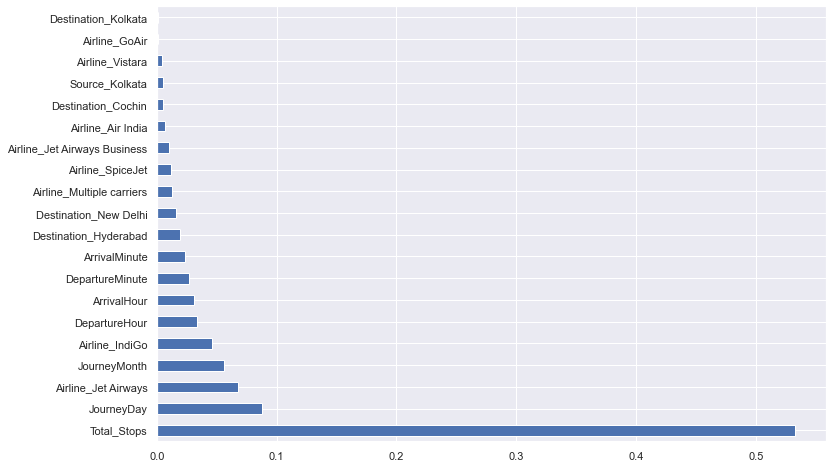

In [69]:
## Get the most important features. ##

#plot graph of feature importances

plt.figure(figsize = (12,8))
feat_importances = pd.Series(reg_rf.feature_importances_, index=x_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [70]:
# Keeping only best 14 features

x_train_imp = x_train[['JourneyDay', 'Airline_Jet Airways', 'Airline_Jet Airways Business', 'JourneyMonth',
                      'ArrivalHour', 'DepartureHour','Total_Stops', 'Airline_IndiGo', 'ArrivalMinute', 'DepartureMinute',
                      'Destination_Hyderabad', 'Destination_New Delhi', 'Airline_Multiple carriers', 'Airline_SpiceJet']]

x_test_imp = x_test[['JourneyDay', 'Airline_Jet Airways', 'Airline_Jet Airways Business', 'JourneyMonth',
                      'ArrivalHour', 'DepartureHour','Total_Stops', 'Airline_IndiGo', 'ArrivalMinute', 'DepartureMinute',
                      'Destination_Hyderabad', 'Destination_New Delhi', 'Airline_Multiple carriers', 'Airline_SpiceJet']]

In [71]:

reg_rf_imp = RandomForestRegressor()
reg_rf_imp.fit(x_train_imp, y_train)


y_pred_rf_imp = reg_rf_imp.predict(x_test_imp)


## Calculate metrics

# training accuracy
train_acc_rf_imp = reg_rf_imp.score(x_train_imp, y_train)

# test accuracy
test_acc_rf_imp = reg_rf_imp.score(x_test_imp, y_test)

print('--------- Metrics --------------')
print('Training accuracy:', train_acc_rf_imp)
print('Test accuracy:', test_acc_rf_imp)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_rf_imp))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_rf_imp))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf_imp)))

--------- Metrics --------------
Training accuracy: 0.9629184740076586
Test accuracy: 0.8413583306485445
MAE: 0.8022915846792834
MSE: 1.5430596557607894
RMSE: 1.2421995233298029


*** Discarding least important features doesn't affect the model accuracy. So, we'll select only the top 14 features, which have high feature importance scores. ***

*** Also, high training accuracy and low test accuracy indicates overfitting. To increase the accuracy of the model, and make it more generalized for the test data, Hyperparameter tuning is required. ***